<a href="https://colab.research.google.com/github/272584/prip_lab1/blob/main/prir_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Oct 16 11:19:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import numpy as np
import time

N = 1024
A_cpu = np.random.rand(N, N).astype(np.float32)
B_cpu = np.random.rand(N, N).astype(np.float32)

start = time.time()
C_cpu = np.matmul(A_cpu, B_cpu)
end = time.time()

print(f"Mnożenie macierzy na CPU trwało: {end - start:.5f} sekund.")

Mnożenie macierzy na CPU trwało: 0.06023 sekund.


In [ ]:
import cupy as cp
import time

N = 1024
A_cpu = np.random.rand(N, N).astype(np.float32)
B_cpu = np.random.rand(N, N).astype(np.float32)

A_gpu = cp.array(A_cpu)
B_gpu = cp.array(B_cpu)

start = time.time()
C_gpu = cp.matmul(A_gpu, B_gpu)
cp.cuda.Stream.null.synchronize()  # Synchronizacja z GPU
end = time.time()

print(f"Mnożenie macierzy na GPU trwało: {end - start:.5f} sekund.")

Mnożenie macierzy na GPU trwało: 0.00119 sekund.


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.9 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=aac9406ae281f3b4f5666f8ef6033d9c85325e725e46e4bf689bc4699752ac85
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [ ]:
kernel_code = """
__global__ void matrixMul(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0;
    if(row < N && col < N) {
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}
"""

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import time

In [ ]:
# Rozmiar macierzy
N = 1024

# Tworzenie macierzy na CPU
A_cpu = np.random.rand(N, N).astype(np.float32)
B_cpu = np.random.rand(N, N).astype(np.float32)

# Kompilacja kernela
mod = SourceModule(kernel_code)
matrixMul = mod.get_function("matrixMul")

# Inicjalizacja pustej macierzy wynikowej
C_cpu = np.empty((N, N), np.float32)

# Alokacja pamięci na GPU
A_gpu = cuda.mem_alloc(A_cpu.nbytes)
B_gpu = cuda.mem_alloc(B_cpu.nbytes)
C_gpu = cuda.mem_alloc(C_cpu.nbytes)

# Przesłanie danych na GPU
cuda.memcpy_htod(A_gpu, A_cpu)
cuda.memcpy_htod(B_gpu, B_cpu)

# Definiowanie rozmiaru bloku (32x32 wątków)
block_size = (32, 32, 1)

# Definiowanie rozmiaru siatki
grid_size = (int(N/32), int(N/32), 1)

# Pomiar czasu i uruchomienie kernela
start = time.time()
matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)

# Synchronizacja z GPU
cuda.Context.synchronize()
end = time.time()

# Pobranie danych z GPU
cuda.memcpy_dtoh(C_cpu, C_gpu)

print(f"Mnożenie macierzy (kernel CUDA) trwało: {end - start:.5f} sekund.")

# Czyszczenie pamięci GPU
del A_gpu
del B_gpu
del C_gpu

Mnożenie macierzy (kernel CUDA) trwało: 0.00694 sekund.


In [ ]:
# Obliczenie referencyjne na CPU
C_reference = np.matmul(A_cpu, B_cpu)

# Porównanie wyników
max_diff = np.max(np.abs(C_cpu - C_reference))
print(f"Maksymalna różnica między wynikami: {max_diff}")

if max_diff < 1e-3:
    print("Wyniki są poprawne")
else:
    print("Wykryto znaczące różnice w wynikach")

Maksymalna różnica między wynikami: 0.000579833984375
Wyniki są poprawne


In [ ]:
import numpy as np
import cupy as cp
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import time
import matplotlib.pyplot as plt

# Kernel CUDA
kernel_code = """
__global__ void matrixMul(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0;
    if(row < N && col < N) {
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}
"""

# Kompilacja kernela
mod = SourceModule(kernel_code)
matrixMul = mod.get_function("matrixMul")

In [ ]:
def test_cpu(N):
    """Mnożenie na CPU (NumPy)"""
    A_cpu = np.random.rand(N, N).astype(np.float32)
    B_cpu = np.random.rand(N, N).astype(np.float32)

    start = time.time()
    C_cpu = np.matmul(A_cpu, B_cpu)
    end = time.time()

    return end - start

def test_gpu_cupy(N):
    """Mnożenie na GPU (CuPy - wysokopoziomowe)"""
    A_cpu = np.random.rand(N, N).astype(np.float32)
    B_cpu = np.random.rand(N, N).astype(np.float32)

    A_gpu = cp.array(A_cpu)
    B_gpu = cp.array(B_cpu)

    start = time.time()
    C_gpu = cp.matmul(A_gpu, B_gpu)
    cp.cuda.Stream.null.synchronize()
    end = time.time()

    return end - start

def test_gpu_cuda(N):
    """Mnożenie na GPU (PyCUDA - niskopoziomowe)"""
    A_cpu = np.random.rand(N, N).astype(np.float32)
    B_cpu = np.random.rand(N, N).astype(np.float32)
    C_cpu = np.empty((N, N), np.float32)

    # Alokacja pamięci
    A_gpu = cuda.mem_alloc(A_cpu.nbytes)
    B_gpu = cuda.mem_alloc(B_cpu.nbytes)
    C_gpu = cuda.mem_alloc(C_cpu.nbytes)

    # Przesłanie danych
    cuda.memcpy_htod(A_gpu, A_cpu)
    cuda.memcpy_htod(B_gpu, B_cpu)

    # Konfiguracja
    block_size = (32, 32, 1)
    grid_size = (int(np.ceil(N/32)), int(np.ceil(N/32)), 1)

    # Wykonanie
    start = time.time()
    matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)
    cuda.Context.synchronize()
    end = time.time()

    # Czyszczenie
    del A_gpu
    del B_gpu
    del C_gpu

    return end - start

In [ ]:
# Rozmiary macierzy do przetestowania
sizes = [128, 256, 512, 1024, 2048, 4096]

# Listy do przechowywania wyników
times_cpu = []
times_gpu_cupy = []
times_gpu_cuda = []

print("Rozpoczynam testy...")
print("-" * 60)

for N in sizes:
    print(f"Testowanie dla N = {N}...")

    # Test CPU
    try:
        t_cpu = test_cpu(N)
        times_cpu.append(t_cpu)
        print(f"  CPU (NumPy):        {t_cpu:.5f} s")
    except Exception as e:
        print(f"  CPU: Błąd - {e}")
        times_cpu.append(None)

    # Test GPU CuPy
    try:
        t_cupy = test_gpu_cupy(N)
        times_gpu_cupy.append(t_cupy)
        print(f"  GPU (CuPy):         {t_cupy:.5f} s")
    except Exception as e:
        print(f"  GPU CuPy: Błąd - {e}")
        times_gpu_cupy.append(None)

    # Test GPU CUDA
    try:
        t_cuda = test_gpu_cuda(N)
        times_gpu_cuda.append(t_cuda)
        print(f"  GPU (PyCUDA):       {t_cuda:.5f} s")
    except Exception as e:
        print(f"  GPU CUDA: Błąd - {e}")
        times_gpu_cuda.append(None)

    print("-" * 60)

print("Testy zakończone!")

Rozpoczynam testy...
------------------------------------------------------------
Testowanie dla N = 128...
  CPU (NumPy):        0.00129 s
  GPU (CuPy):         0.00035 s
  GPU (PyCUDA):       0.00010 s
------------------------------------------------------------
Testowanie dla N = 256...
  CPU (NumPy):        0.00043 s
  GPU (CuPy):         0.00029 s
  GPU (PyCUDA):       0.00018 s
------------------------------------------------------------
Testowanie dla N = 512...
  CPU (NumPy):        0.00222 s
  GPU (CuPy):         0.00040 s
  GPU (PyCUDA):       0.00096 s
------------------------------------------------------------
Testowanie dla N = 1024...
  CPU (NumPy):        0.01733 s
  GPU (CuPy):         0.00119 s
  GPU (PyCUDA):       0.00682 s
------------------------------------------------------------
Testowanie dla N = 2048...
  CPU (NumPy):        0.15758 s
  GPU (CuPy):         0.00748 s
  GPU (PyCUDA):       0.05370 s
------------------------------------------------------------
T

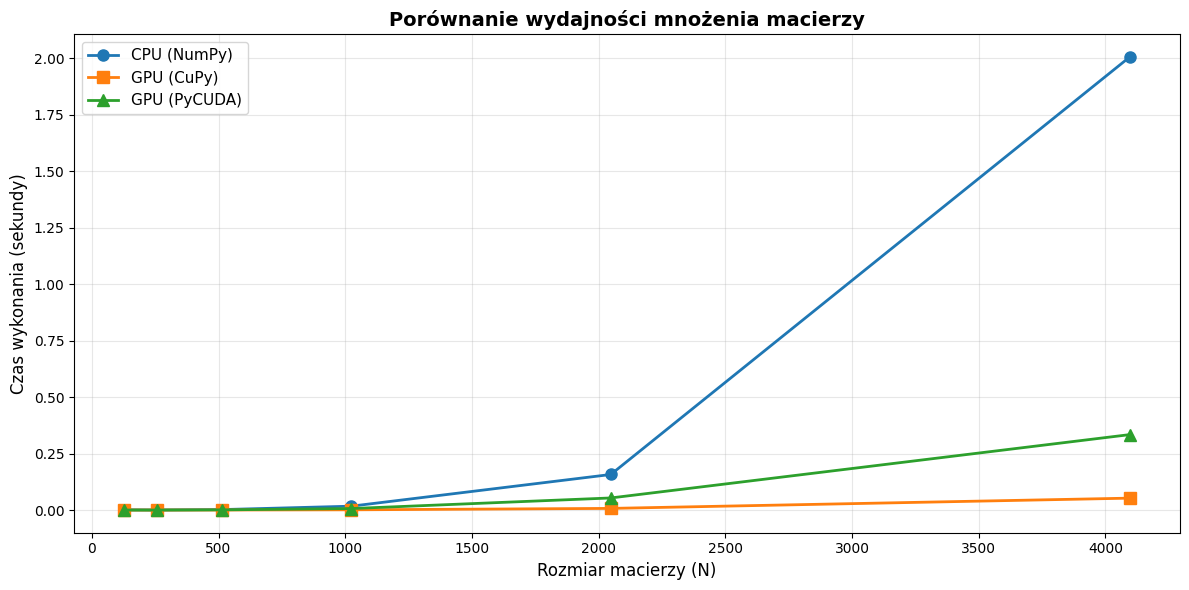

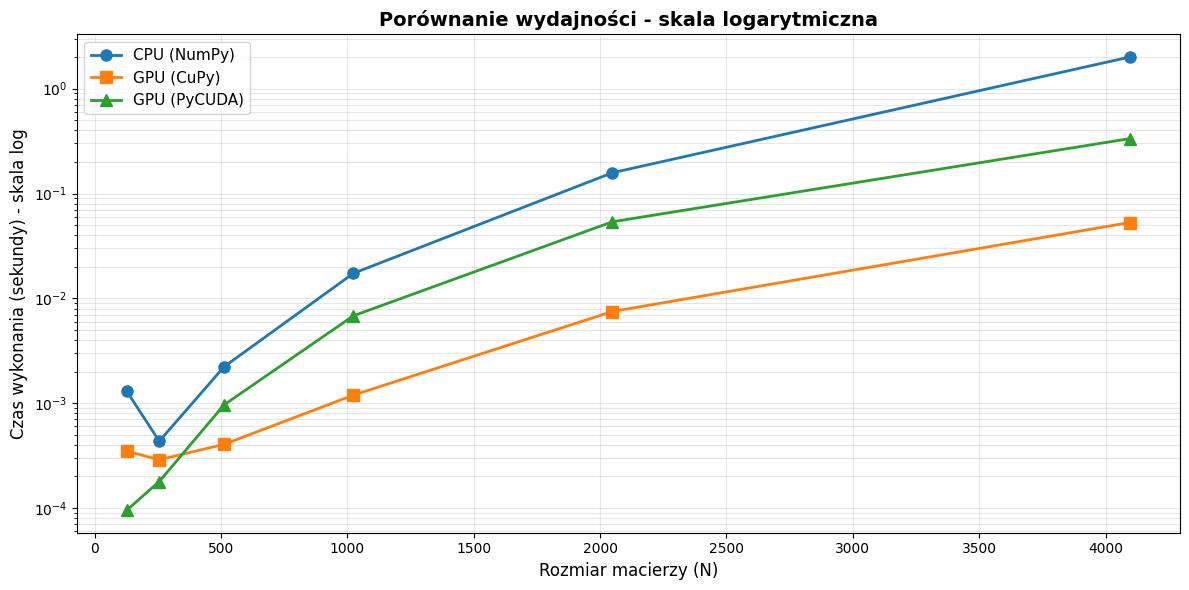

In [ ]:
# Wykres 1: Porównanie wszystkich metod
plt.figure(figsize=(12, 6))

plt.plot(sizes, times_cpu, marker='o', linewidth=2, markersize=8, label='CPU (NumPy)')
plt.plot(sizes, times_gpu_cupy, marker='s', linewidth=2, markersize=8, label='GPU (CuPy)')
plt.plot(sizes, times_gpu_cuda, marker='^', linewidth=2, markersize=8, label='GPU (PyCUDA)')

plt.xlabel('Rozmiar macierzy (N)', fontsize=12)
plt.ylabel('Czas wykonania (sekundy)', fontsize=12)
plt.title('Porównanie wydajności mnożenia macierzy', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Wykres 2: Skala logarytmiczna (lepiej widać różnice)
plt.figure(figsize=(12, 6))

plt.plot(sizes, times_cpu, marker='o', linewidth=2, markersize=8, label='CPU (NumPy)')
plt.plot(sizes, times_gpu_cupy, marker='s', linewidth=2, markersize=8, label='GPU (CuPy)')
plt.plot(sizes, times_gpu_cuda, marker='^', linewidth=2, markersize=8, label='GPU (PyCUDA)')

plt.xlabel('Rozmiar macierzy (N)', fontsize=12)
plt.ylabel('Czas wykonania (sekundy) - skala log', fontsize=12)
plt.title('Porównanie wydajności - skala logarytmiczna', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

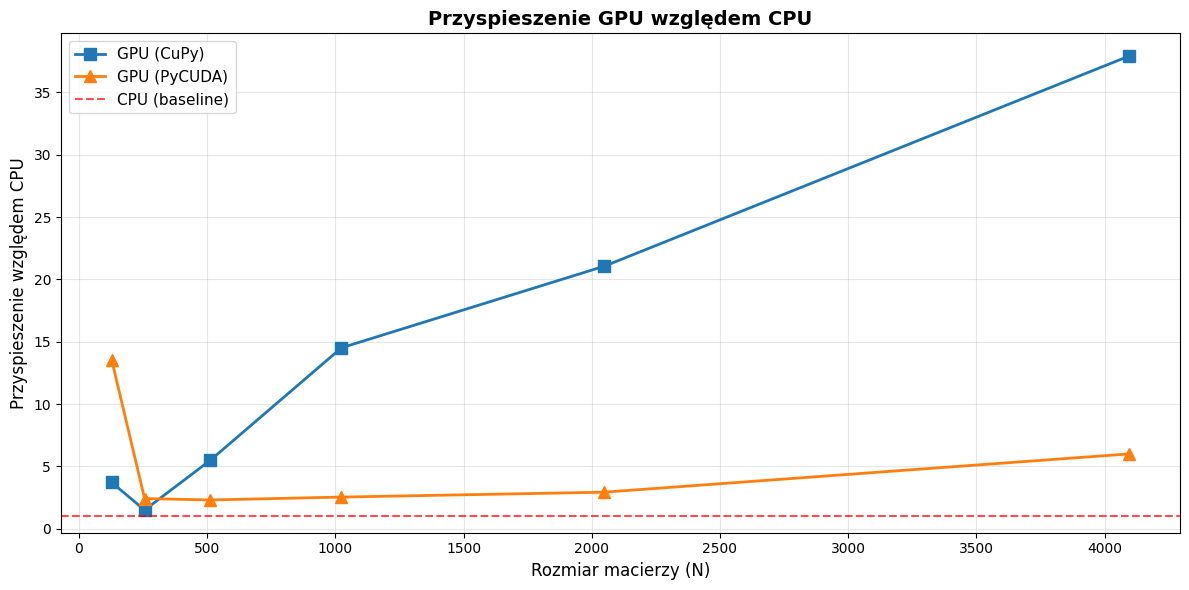


Tabela wyników:
N        CPU (s)      CuPy (s)     CUDA (s)     Speedup CuPy    Speedup CUDA   
128      0.00129      0.00035      0.00010      3.71           x 13.52          x
256      0.00043      0.00029      0.00018      1.50           x 2.42           x
512      0.00222      0.00040      0.00096      5.49           x 2.31           x
1024     0.01733      0.00119      0.00682      14.52          x 2.54           x
2048     0.15758      0.00748      0.05370      21.05          x 2.93           x
4096     2.00540      0.05289      0.33403      37.92          x 6.00           x


In [ ]:
# Wykres 3: Przyspieszenie względem CPU
plt.figure(figsize=(12, 6))

speedup_cupy = [times_cpu[i] / times_gpu_cupy[i] if times_gpu_cupy[i] else 0
                for i in range(len(sizes))]
speedup_cuda = [times_cpu[i] / times_gpu_cuda[i] if times_gpu_cuda[i] else 0
                for i in range(len(sizes))]

plt.plot(sizes, speedup_cupy, marker='s', linewidth=2, markersize=8, label='GPU (CuPy)')
plt.plot(sizes, speedup_cuda, marker='^', linewidth=2, markersize=8, label='GPU (PyCUDA)')
plt.axhline(y=1, color='r', linestyle='--', label='CPU (baseline)', alpha=0.7)

plt.xlabel('Rozmiar macierzy (N)', fontsize=12)
plt.ylabel('Przyspieszenie względem CPU', fontsize=12)
plt.title('Przyspieszenie GPU względem CPU', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Wyświetlenie wyników w tabeli
print("\nTabela wyników:")
print("=" * 80)
print(f"{'N':<8} {'CPU (s)':<12} {'CuPy (s)':<12} {'CUDA (s)':<12} {'Speedup CuPy':<15} {'Speedup CUDA':<15}")
print("=" * 80)
for i, N in enumerate(sizes):
    print(f"{N:<8} {times_cpu[i]:<12.5f} {times_gpu_cupy[i]:<12.5f} {times_gpu_cuda[i]:<12.5f} "
          f"{speedup_cupy[i]:<15.2f}x {speedup_cuda[i]:<15.2f}x")
print("=" * 80)